In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [2]:
data_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Training and Validation')
test_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1520


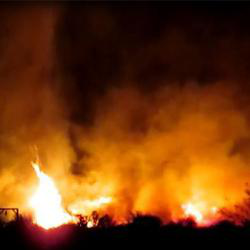

In [4]:
fire = list(data_dir.glob('fire/*'))
img = PIL.Image.open(str(fire[0]))
display(img)

### Load data into a tf dataset

In [5]:
batch_size = 32
img_height = 160
img_width = 160

# Validation split 80/20

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

Found 1520 files belonging to 2 classes.
Using 1216 files for training.


2022-03-22 11:16:56.097835: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-22 11:16:56.099181: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-22 11:16:56.103043: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size    
    )


Found 1520 files belonging to 2 classes.
Using 304 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

Found 380 files belonging to 2 classes.


### Get Class Names

In [8]:
class_names = train_ds.class_names
print(class_names)

['fire', 'nofire']


### Visualise Data

2022-03-22 11:17:00.488550: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-22 11:17:00.506867: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3193770000 Hz


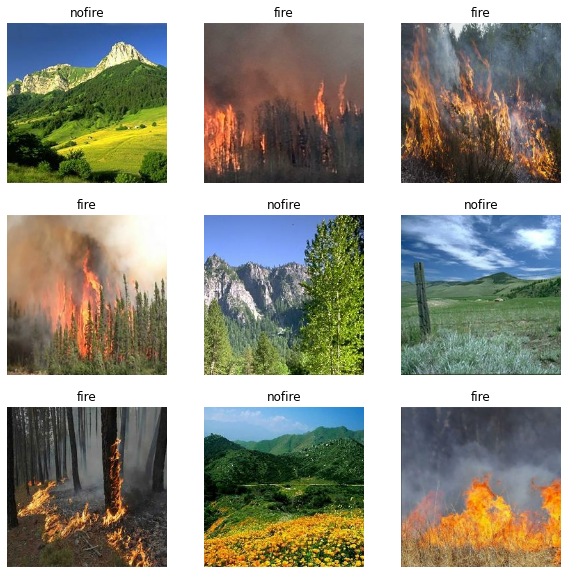

In [9]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

### Create the base model from pre-trained convnets

In [11]:
## By specifying "include_top=False" argument you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction

IMG_SHAPE = (img_width, img_height) + (3,)
# base_model = tf.keras.applications.EfficientNetV2B0(input_shape = IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
    classifier_activation="sigmoid",
)


image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


## Feature Extraction

In [12]:
base_model.trainable = False
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 160, 160, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 160, 160, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 161, 161, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

## Add classification head

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
prediction_layer = tf.keras.layers.Dense(1, 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


### Chain together the model

In [15]:
inputs = tf.keras.Input(shape = (160, 160, 3))
x = base_model(inputs, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [16]:
# Useful metrics paper:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=(True)),
              metrics = [tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall"),tf.keras.metrics.AUC(name = "auc")] )

In [17]:

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 5, 5, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


## Train the model

In [18]:
# Tests the initial base model
initial_epochs = 10
loss0, precision0, recall0, auc0 = model.evaluate(val_ds)

10/10 [==============================] - 12s 614ms/step - loss: 0.6551 - precision: 0.5709 - recall: 0.5892 - auc: 0.6741


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial precision: {:.2f}".format(precision0))
print("initial recall: {:.2f}".format(recall0))
print("initial auc: {:.2f}".format(auc0))

initial loss: 0.65
initial precision: 0.64
initial recall: 0.58
initial auc: 0.70


In [21]:
history = model.fit(train_ds,
                    epochs = initial_epochs,
                    validation_data = val_ds)

Epoch 1/10
38/38 [==============================] - 46s 898ms/step - loss: 0.6128 - precision: 0.7247 - recall: 0.6203 - auc: 0.7741 - val_loss: 0.5652 - val_precision: 0.8473 - val_recall: 0.7450 - val_auc: 0.8943
Epoch 2/10
38/38 [==============================] - 35s 908ms/step - loss: 0.5354 - precision: 0.8538 - recall: 0.7741 - auc: 0.9097 - val_loss: 0.4957 - val_precision: 0.9078 - val_recall: 0.8591 - val_auc: 0.9626
Epoch 3/10
38/38 [==============================] - 35s 906ms/step - loss: 0.4712 - precision: 0.9400 - recall: 0.8723 - auc: 0.9650 - val_loss: 0.4383 - val_precision: 0.9448 - val_recall: 0.9195 - val_auc: 0.9822
Epoch 4/10
38/38 [==============================] - 35s 926ms/step - loss: 0.4248 - precision: 0.9384 - recall: 0.8969 - auc: 0.9807 - val_loss: 0.3907 - val_precision: 0.9463 - val_recall: 0.9463 - val_auc: 0.9893
Epoch 5/10
38/38 [==============================] - 34s 899ms/step - loss: 0.3843 - precision: 0.9549 - recall: 0.9362 - auc: 0.9887 - val_l

### Learning Curves

Found 380 files belonging to 2 classes.


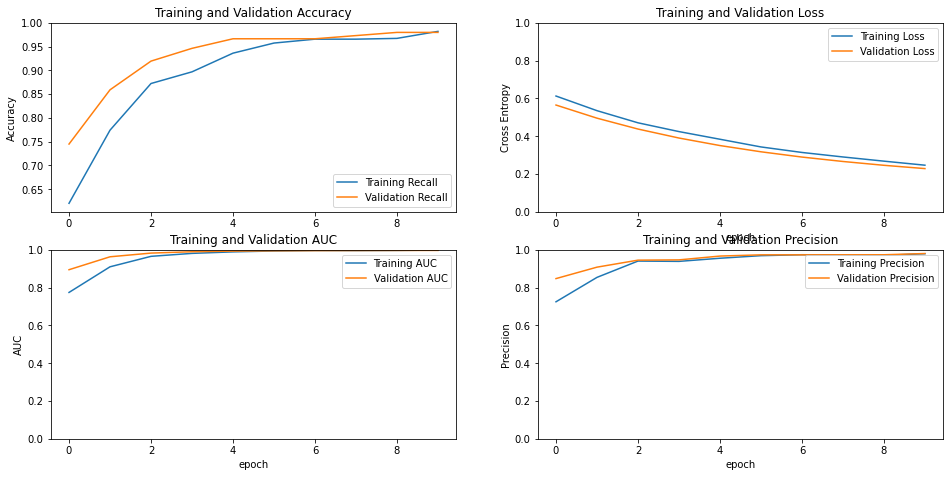

In [22]:
recall = history.history['recall']
val_recall = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

auc = history.history['auc']
val_auc = history.history['val_auc']

precision = history.history['precision']
val_pre = history.history['val_precision']

plt.figure(figsize = (16, 16))
plt.subplot(4, 2, 1)
plt.plot(recall, label = 'Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

plt.subplot(4, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(4, 2, 3)
plt.plot(auc, label = 'Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0,1.0])
plt.title('Training and Validation AUC')
plt.xlabel('epoch')

plt.subplot(4, 2, 4)
plt.plot(precision, label = 'Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0,1.0])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')
plt.show()




## Fine Tuning

In [23]:
# Previously the base model weights were not updated and only a few layers on top of the EfficientNetV2 was trained
# Unfreeze and train the top layers of the pre-trained model to fine tune to the dataset

## Un-freeze top layers of the model

base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  237


In [25]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile the Model

In [26]:
## Important to use a lower training weight since using more layers, otherwise
# it could overfit very quickly 

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = [tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall"),tf.keras.metrics.AUC(name = "auc")])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 5, 5, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 3,841,629
Non-trainable params: 209,223
_________________________________________________________________


In [27]:
print(len(model.trainable_variables))


125


### Continue Training the Model

In [28]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = val_ds)


Epoch 10/20
38/38 [==============================] - 127s 3s/step - loss: 0.1815 - precision: 0.9878 - recall: 0.9770 - auc: 0.9979 - val_loss: 0.0895 - val_precision: 0.9867 - val_recall: 0.9933 - val_auc: 0.9974
Epoch 11/20
38/38 [==============================] - 95s 3s/step - loss: 0.0708 - precision: 0.9900 - recall: 0.9942 - auc: 0.9998 - val_loss: 0.0525 - val_precision: 0.9867 - val_recall: 0.9933 - val_auc: 0.9977
Epoch 12/20
38/38 [==============================] - 95s 3s/step - loss: 0.0352 - precision: 0.9917 - recall: 0.9974 - auc: 0.9999 - val_loss: 0.0404 - val_precision: 0.9867 - val_recall: 0.9933 - val_auc: 0.9975
Epoch 13/20
38/38 [==============================] - 92s 2s/step - loss: 0.0192 - precision: 0.9936 - recall: 0.9971 - auc: 0.9999 - val_loss: 0.0374 - val_precision: 0.9867 - val_recall: 0.9933 - val_auc: 0.9958
Epoch 14/20
38/38 [==============================] - 98s 3s/step - loss: 0.0151 - precision: 0.9933 - recall: 1.0000 - auc: 0.9999 - val_loss: 0.03

### Learning Curves

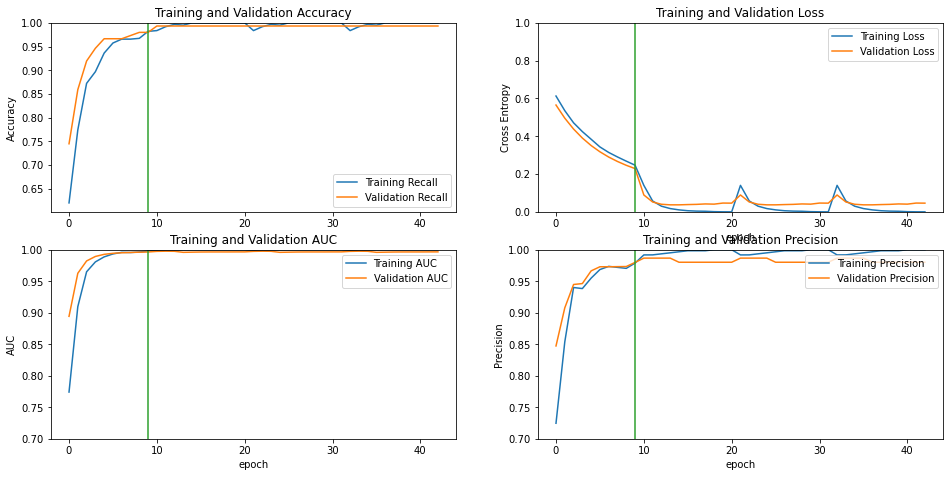

In [31]:
recall += history_fine.history['recall']
val_recall += history_fine.history['val_recall']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

auc += history_fine.history['auc']
val_auc += history_fine.history['val_auc']

precision += history_fine.history['precision']
val_pre += history_fine.history['val_precision']

plt.figure(figsize = (16, 16))
plt.subplot(4, 2, 1)
plt.plot(recall, label = 'Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Accuracy')

plt.subplot(4, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(4, 2, 3)
plt.plot(auc, label = 'Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0.7,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation AUC')
plt.xlabel('epoch')

plt.subplot(4, 2, 4)
plt.plot(precision, label = 'Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0.7,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Precision')
plt.xlabel('epoch')
plt.show()




In [32]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )


test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

Found 380 files belonging to 2 classes.


## Verifying on test set

In [68]:
loss, precision, recall, auc = model.evaluate(test_ds)
print('Test loss :', loss)
print('Test precision :', precision)
print('Test recall :', recall)
print('Test auc :', auc)

12/12 [==============================] - 9s 692ms/step - loss: 0.0464 - precision: 0.9893 - recall: 0.9737 - auc: 0.9968
Test loss : 0.04639245569705963
Test precision : 0.9893048405647278
Test recall : 0.9736841917037964
Test auc : 0.9968144297599792


In [69]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# pred = model.predict(test_ds)
# pred = np.argmax(pred, axis = 1)[:5]
# label = 

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)

In [70]:
print(np.round(predictions, 3))

[0.    0.077 0.    1.    0.    0.    1.    1.    0.    1.    1.    1.
 1.    1.    1.    0.    1.    1.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    1.    1.    1.    0.    0.018]


In [71]:
predictions = tf.where(predictions < 0.5, 0, 1)
print(predictions)

tf.Tensor([0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0], shape=(32,), dtype=int32)


Predictions:
 [1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0]
Labels:
 [1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0]


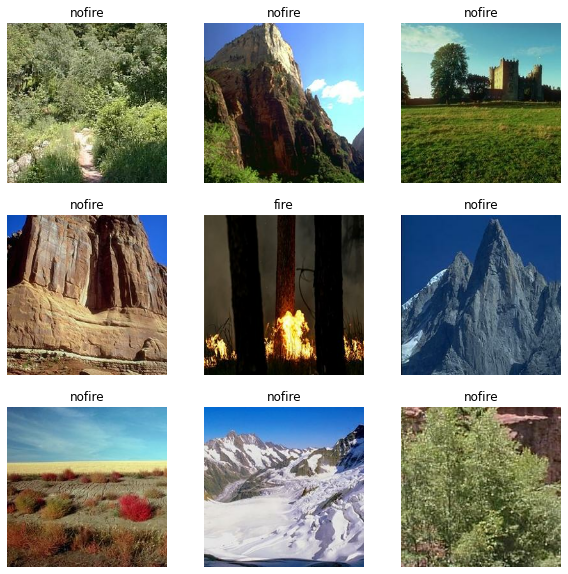

In [72]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# pred = model.predict(test_ds)
# pred = np.argmax(pred, axis = 1)[:5]
# label = 

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# LOOK AT EXTRACTING THE MISSCLASSIFIED IMAGES AND TALK ABOUT WHY THEY HAVE BEEN MISSCLASSIFIED (SIMILAR FEATURES, LOOKS LIKE A SUNSET ETC)

### Confusion Matrix

In [73]:
import pandas as pd
con_mat = tf.math.confusion_matrix(labels = label_batch, predictions=predictions).numpy()
con_mat_norm = np.around(con_mat.astype('float')/con_mat.sum(axis = 1)[:, np.newaxis], decimals = 2)

#con_mat_df = pd.DataFrame(con_mat_norm,
con_mat_df = pd.DataFrame(con_mat,
                          index = class_names,
                          columns = class_names)


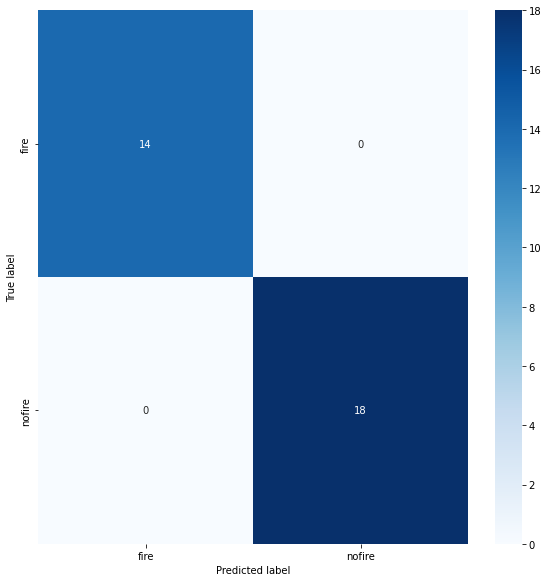

In [74]:
import seaborn as sns
figure = plt.figure(figsize = (8, 8))
sns.heatmap(con_mat_df, annot = True, cmap = plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [52]:
model.save('model00_EfficientNetB0.h5')

In [55]:
loaded_model = tf.keras.models.load_model('model00_EfficientNetB0.h5')

In [67]:
from tensorflow.keras.preprocessing import image

test_image = image.load_img(f'{test_dir}/nofire/abc192.jpg', target_size = (160,160))
test_image = image.img_to_array(test_image)
test_image = test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = loaded_model.predict(test_image)

print(result)


[[0.40929052]]


In [43]:

if result[0]<0.5:
    print("The image classified as no fire")
else:
    print("The image classified as fire")

The image classified as no fire
